# Quantum Quickstarter for industry

Recall that Alice wants to help Bob solve his supply chain problem. Bob has six customer orders, all have a certain size (number of chips) and promise Bob a certain revenue. Bob's machines can produce seven wafer chips, so he has to decide, which orders to fulfill and which to postpone to another day. Of course, he wants to maximize his profit under the contraint of not overstepping the capacity of his machines. See the illustration

<img src="fab_problem.png" width="600" />

### Exercise 1 
Try different configurations for choosing the customer orders. Try to maximize the total revenue while not violating the constraint.

# Knapsack Problem

In optimization theory, Bob's task is called the *knapsack problem*. The customer orders are called *items*, their size is called *weight* and their revenue *value*. Bob's fab is called the *knapsack*. Now the task consists of packing items into the knapsack such that 

- their total weight does not exceed the capacity and
- their total value is maximized.

The next thing to do is to set up a mathematical formulation for our optimization task, expressing it in terms of concrete formulae.

To this end, we set up binary variables $x_1,x_2,...,x_6$, where $x_i=1$ indicates that item $i$ goes into the knapsack and $x_i=0$ indicates that it does not. As an example, the bitstring $(1, 0, 0, 1, 1, 0)$ encodes packing the first, fourth and fifth item into the knapsack.

Now, the weights and values are introduced into our model by assigning positive integers $v_i$ (value of item $i$) and $w_i$ (weight of item $i$) to each item $i$. The capacity of the knapsack is another positive integer $C$. Now we are ready to formulate our objective terms of formulae:

$\max_{(x_1,...,x_6) \in \{0,1\}^6} \sum_{i \in \{1,...,6\}} x_i \cdot v_i$

such that $\sum_{i \in \{0,1\}^6}w_i \cdot x_i \leq C$.


# From Knapsack to QUBO to Hamiltonian

One very common way to apply quantum algorithms to an optimization task is to construct a *Hamiltonian*, whose lowest energy eigenstate corresponds to the solution to our optimization task. The encoding into a Hamiltonian enables us to implement an algorithm for our problem on the quantum mechanical system living inside our quantum computer.

## QUBO problems

A standard approach towards a Hamiltonian encoding is to formulate the optimization task as a *QUBO* problem, where QUBO stands for **Q**uadratic **U**nconstrained **B**inary **O**ptimization.

Recall that our mathematical formulation of the knapsack problem is

$\max_{(x_1,...,x_6) \in \{0,1\}^6} \sum_{i \in \{1,...,6\}} x_i \cdot v_i$

such that $\sum_{i \in \{0,1\}^6}w_i \cdot x_i \leq C$.

This formulation is already *binary*, i.e. it uses binary variables and *quadratic*, i.e. there are no terms of higher powers than $2$. However, it is not yet *unconstrained*, as there is the constraint not to overstep the capacity of the knapsack.

In order to get rid of this constraint, we want to add it to the goal function as a *penalty term*. A penalty term is designed such that it adds a large penalty in case the constraint is violated, thus making such configurations unattractive to an optimization algorithm.

More concretely, a sensible first guess for a penalty term to our knapsack problem is

$$E_{\text{penalty}}= (\sum_i w_i \cdot x_i - C)^2.$$

This term is positive whenever the total weight $\sum_i w_i \cdot x_i$ exceeds the capacity $C$. The issue with this first draft of the penalty term is that we penalize **understepping** the capacity $C$ just as much as overstepping. This is indeed a problem, since there are many configurations in which the optimal configuration does not exactly fill the knapsack.

To resolve this issue, we resort to a commonly used trick and introduce *helper variables* $y_n$ for $1\leq n\leq C$. Setting $y_n = 1$ indicates that the total weight of the items in the knapsack is $n$. Clearly, in a correct configuration, exactly one of the helper variables $y_n$ must be $1$ as there is only one total weight of the packed items.
This condition is encoded in the penalty term

$$E_{\text{helper-penalty}} = (1-\sum_n y_n)^2$$

which penalizes any configuration where more or less than one helper variable evaluates to $1$.

Now we require that the total weight of the items $\sum_i w_i \cdot x_i$ be equal to the total weight indicated by the helper variables $\sum_n n \cdot y_n$. This is encoded in the penalty term

$$E_{\text{capacity-penalty}} = (\sum_i w_i \cdot x_i -\sum_n n \cdot y_n)^2.$$

Combining all three terms, we finally get a QUBO formulation of the knapsack problem:

$$\min_{(x_1,...,x_6) \in \{0,1\}^6} A \cdot (E_{\text{helper-penalty}} + E_{\text{capacity-penalty}}) - \sum_i c_i \cdot x_i,$$

where $A > 0$ is a weighting factor for the penalty term.
If we have $N$ items and a maximal total capacity of $C$, the number of variables needed scales linearly with:

$$\#\text{number of qubits} = N + ⌈C⌉.$$

### Exercise 2
How would you choose the weighting factor $A$ for the penalty term? Choose from

1. $A=1$
2. $A=10$
3. $A=10000$

and explain your choice.

## Hamiltonian

As a last step we can map this QUBO formulation to an Ising-Model, using the universal translation rules

$$x_i \leftrightarrow (I - Z_i) \text{   and   } x_i \cdot x_j \leftrightarrow (I - Z_i) (I - Z_j)$$

where $Z_i$ deontes a Pauli $Z$ operation on the $i$-th qubit of a system with multiple qubits and $I$ denotes the identity operator.
We have thus constructed the desired Hamiltonian and are now ready to run a quantum algorithm which finds its ground state, thereby giving us the solution to our knapsack problem.



### Test exercise (after the course)

Go to the TSP notebook and try to come up with a QUBO formulation yourself.


## Variational quantum algorithms

Since we have encoded our optimization task into a Hamiltonian, i.e. into physical data, we go to the algorithmic phase. We will solve our QUBO problem with two different variational quantum algorithms. First, let's import the necessary Qiskit classes, and set up an optimizer and simulator to use.

In [11]:
import numpy as np
import matplotlib.pyplot as plt 
from qiskit import IBMQ

from qiskit.algorithms import QAOA, VQE
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA
from qiskit import Aer

#Simulator
backend = Aer.get_backend('statevector_simulator')
#Optimizer
optimizer = COBYLA(maxiter=1000, tol=0.0001)

#load the qubo
qp = QuadraticProgram()
qp.read_from_lp_file('test_knapsack.lp')

### The variational method

We want to find the lowest energy state $\ket{\psi^*}$ of a quantum system. The variational method has two steps:

- Choose a parametrized quantum circuit $U(\theta)$, also called *trial state* or *ansatz*
- Vary parameters $\theta$ to minimize the energy value $E(\theta)=\bra{0}^{\otimes n}U(\theta)^{\dagger} H U(\theta) \ket{0}^{\otimes n}$ and find: $\theta^* = \text{arg}\min_{\theta}E(\theta)$

In general we will have multiple parameters to optimize over, i.e. $\theta \in \mathbb{R}^n$ for some $n \in \mathbb{N}$. We can use a classical optimization technique of our choice to tune these parameters $\theta_i$ after each execution and measurement of the circuit.


## VQE

The most general variational algorithm is the variational quantum eigensolver, *VQE* for short. We can freely choose an ansatz, many sensible choices can be found in the Qiskit circuit library.
We can easily implement and run our QUBO with the Qiskit VQE class.

In [12]:
#VQE
form=EfficientSU2(num_qubits=9,su2_gates=['rx', 'z'], entanglement='full', reps=1)
vqe_mes=VQE(form,optimizer = optimizer, quantum_instance = backend)

# construct Minimum Eigen Optimizer based on QAOA
vqe = MinimumEigenOptimizer(vqe_mes)

# solve Quadratic Program
result = vqe.solve(qp)
print(result)

optimal function value: -10.0
optimal value: [1. 0. 0. 1. 1. 1. 0. 0. 1.]
status: SUCCESS


Try executing the VQE cell multiple times. You will observe that the result varies and the optimal value (energy -11) is not always found. One method for improving the result is to tailor the ansatz to our specific problem instance. This leads us to a subclass of VQE, known as *QAOA*.

## QAOA
QAOA (Quantum Approximate Optimization Algorithms) is a variational algorithm using a quantum circuit inspired by the adiabatic theorem: If the Hamiltonian of a quantum system in its ground state is perturbed slowly enough, the system remains in its ground state.

Previously, we derived an encoding of our problem into a Hamiltonian $H_C$ whose ground state has the problem solution. Our overall strategy will be to adiabatically evolve a simple Hamiltonian $H_M$ to the problem Hamiltonian $H_C$
$$H(t)=\frac{t}{T}H_C+(1-\frac{t}{T})H_M,$$
where $T$ denotes the runtime. The evolution is made up of two different layers and is repeated $p$ times, which in the limit recovers the adiabatic theorem: $$e^{-iH(t)\Delta t}=e^{-i(\frac{t}{T}H_C+(1-\frac{t}{T})H_M)\Delta t}=\lim_{p\to\infty}\Big(e^{-i\gamma H_C}e^{-i\beta H_M}\Big)^p,$$ 
with $\gamma = (1-\frac{t}{T})\Delta t$, $\beta = \frac{t}{T}\Delta t$, and $p\Delta t=T$. For $p$ layers we end up with $2p$ parameters we have to optimize over in each optimization step.

We can implement and run our QUBO with the Qiskit QAOA class.


In [13]:
# construct QAOA and the Minimum Eigen Optimizer
qaoa_mes = QAOA(reps=1, optimizer=optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))
qaoa = MinimumEigenOptimizer(qaoa_mes)

# solve
result = qaoa.solve(qp)
print(result)

optimal function value: -11.0
optimal value: [1. 0. 1. 1. 0. 0. 0. 0. 1.]
status: SUCCESS


Observe that the QAOA method produces much more reliable results. If you execute the code cell muliple times you will very likely get the optimal solution every single time. Nevertheless, the noisy intermediate scale quantum era (*NISQ era*) presents challenges to quantum researchers and engineers.

### Challenges in the NISQ-Era

Given the noise on current NISQ-devices we will be limited to a small number of noisy gates we can apply before all the noise builds up to an amount that the computation fails completely. As a result there is a trade off between repetitions $p$ chosen and number of gates we can perform.

Besides noise a basic obstacle with arbitrary QUBO formulations is the structure of the energylandscape. Many energylandscapes challenge classical optimizers as they exhibit a lot of local minima, making it hard to find the global minimum. Further, many Hamiltonian formulations exhibit very small energy gaps. Smaller energy gaps require a slower evolution to be adiabatic, thus a higher number of layers $p$ which in turn leads to greater problems with noise and parameter optimization.

As an example, let's have a look at the energylandscape of our formulated QUBO. Due to laptop performance, we can only look have a low resolution precomputed landscape. Nevertheless, it illustrates the complicated nature of QAOA optimization landscapes.

In [14]:
#import precomputed energylandscape of QUBO to interact with
import json
data_points = json.load(open("energylandscape_data.txt"))

import pandas as pd
import plotly.graph_objects as go

#create and display surface plot from data_points
df = pd.DataFrame(data_points)
df = df.pivot(index='beta', columns='gamma', values='energy')
matrix = df.to_numpy()
beta_values = df.index.tolist()
gamma_values = df.columns.tolist()

surface_plot = go.Surface(x=gamma_values, y=beta_values,z=matrix, colorscale ='Blues')
fig = go.Figure(data = surface_plot)
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title_text='Energylandscape', scene = dict(
                    xaxis_title='Parameter: gamma',
                    yaxis_title='Parameter: beta',
                    zaxis_title='Energy'),
                    )
fig.show()

As mentioned, on NISQ-devices qubits and gates are subject to noise. This deeply affects the performance of a quantum algorithm. With the help of Qiskit we can set up a simple noise model and observe how our computational states get randomized.

In [15]:
#Create a basic noise model
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error

def get_noise(p_meas, p_reset,p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_reset = pauli_error([('X',p_reset), ('I', 1 - p_reset)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_reset, "reset") # reset error 
    noise_model.add_all_qubit_quantum_error(error_gate1, ['h', 'id', 'rz', 'sx', 'x']) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

Job Status: job has successfully run


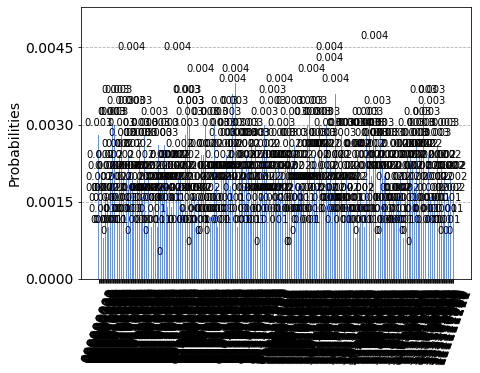

In [16]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile
from qiskit.visualization import plot_histogram

op, offset = qp.to_ising()

ansatz = QAOAAnsatz(op, reps = 1)  
qc = ansatz.bind_parameters([0.123, 0.432])
qc.measure_all()
qc_trans = transpile(qc,backend)
p = 0.1
job = backend.run(qc_trans, noise_model=get_noise(p,p,p), shots = 5000)
job_monitor(job)
    
counts = job.result().get_counts(qc_trans)
plot_histogram(counts)

As we can see, on an average error per gate of $10%$, we can no longer identify the optimal solution.

## Outlook

### Other variational algorithms
As previously mentioned, different algorithms perform well for different problems and encodings. Simple VQE or QAOA ansatzes can easily fail and improvements on existing variational algorithms and other quantum methods is a topic of current research and evolving at a fast pace. Some notable mentions on trying to improve QAOA is recursive-QAOA (RQAOA) and Warm-starting QAOA (WQAOA). 

RQAOA was introduced, since some Hamiltonians exhibit highly entangled ground states that cannot be prepared by shallow quantum circuits. This results in a version of the No Low-Energy Trivial States (NLTS) conjecture and limits the performance of variational algorithms like QAOA. Trying to overcome this problem, RQAOA was suggested in (https://arxiv.org/abs/1910.08980) and can be found in the Qiskit RecursiveMinimumEigenOptimize class.

A further approach to improve QAOA was taken in (https://arxiv.org/abs/2009.10095) with WQAOA and can be found in Qiskit as WarmStartQAOAOptimizer (part of the qiskit_optimization.algorithms class). The main idea behind WQAOA is to initialize the quantum algorithm with a classically pre-solved solution (i.e. a relaxation of a combinatorial optimization problem). With the proper adjustments to the quantum circuit, the quantum algorithm inherits the performance guarantees of the classical algorithm.

Another promising approach to find the ground-state of our encoded problem in the Hamiltonian is via Quantum imaginary time evolution (QITE) (e.g. https://www.nature.com/articles/s41534-019-0187-2). The idea is motivated by classical imaginary-time evolution methods widely used in physics to obtain the ground state in a quantum many-body system. 

### Error mitigation

In the NISQ-Aera noise dominates the performance of any quantum algorithm. As a result error-mitigation is very important for good performance. Two such error-mitigation techniques are Zero Noise Extrapolation (ZNE) and Probabilistic error cancellation (PEC).

The idea behind ZNE is to mitigate systematic errors when executing quantum algorithms on quantum-devices (e.g. https://arxiv.org/abs/1612.02058, https://arxiv.org/abs/2005.10921). It has two main components: noise scaling and then extrapolation. At the gate level, noise is amplified by mapping gates (or groups of gates) $G\mapsto G G^{\dagger}G$. This makes the circuit longer (adding more noise) while keeping its effect unchanged. Based on the number of concatenations one can extrapolate and take into account systematic errors.

PEC (e.g. https://arxiv.org/abs/2108.02237) is based on the idea of expressing ideal gates as linear combinations of implementable noisy gates called quasi-probability representations. Next is to probabilistically sample from the quasi-probability representations and approximate quantum expectation values via a Monte Carlo average. Using both of these steps one can get an unbiased estimation of an expectation values.
